In [8]:
import pickle
p = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b+lora:r=256:a=256/lima.pkl'
with open(p, 'rb') as f:
    x = pickle.load(f)
list(x.keys())

['text_embedding',
 'log_prob',
 'el2n_agg=mean',
 'el2n_agg=l2n',
 'logit_margin',
 'grad_loraB_l2n']

In [5]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 0
test_run = bool(test_run)

model_name = 'llama-7b'
model_name = 'llama-7b+lora:r=256:a=256' # includes lora grad norm
# model_name = 'llama-7b_ft=hmv1' # means llama-7b finetuned on tulu humanmix already.
sort_by_list = [
    'random_s=0', 
    'log_prob', 'logit_margin', 'el2n_agg=mean',  'el2n_agg=l2n',
    'grad_loraB_l2n',
    'dppmap_k=Kcos', 'dppmap_k=Kcosp', 'dppmap_k=Kcos1np', 
    'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
]
sort_by_list = [
    'kmeansl2_emb=grad+rp+loraB_nc=300',
#     'kmeansl2_emb=grad+rp+loraB_nc=1000',
#     'kmeansl2_emb=grad+rp+loraB_nc=3000',
#     'kmeansl2_emb=grad+rp+loraB_nc=6000',
#     'kmeansl2_emb=text+embedding_nc=3000',
]
dataset_list = ['flan2022_1m']

# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import lm_output_dir, data_inds_dir
save_dir = os.path.join(data_inds_dir, model_name)
lm_output_dir = os.path.join(lm_output_dir, model_name)

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --lm_output_dir {lm_output_dir} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = False

Submiting job with:
{
    "job_name": "prune.flan2022_1m.kmeansl2_emb=grad+rp+loraB_nc=300",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset flan2022_1m --sort_by kmeansl2_emb=grad+rp+loraB_nc=300 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b+lora:r=256:a=256 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256
#cmds:  1


In [5]:
path = ('/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/'
    'pythia-1b-deduped')




dataset = 'lima'
model_name = 'llama-7b+lora:r=256:a=256'

from note_pruning_analysis import get_lm_output

output = get_lm_output(dataset, model_name, return_text_embedding=False)
output.keys()


dict_keys(['log_prob', 'el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin', 'grad_loraB_l2n', 'grad_rp_loraB'])

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


1
Thu Oct 19 17:24:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   33C    P0    77W / 300W |   2200MiB / 32510MiB |     74%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A 

In [3]:
from note_pruning_analysis import get_dataset

ds = get_dataset('sharegpt', processed=True)
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Dataset({
    features: ['dataset', 'id', 'messages'],
    num_rows: 160564
})

{'dataset': 'sharegpt',
 'id': 'sharegpt_Og9h3C1_0',
 'messages': [{'role': 'user',
   'content': "root@openvpn:/home/openvpn# ./openvpn-install.sh\nWelcome to OpenVPN-install!\nThe git repository is available at: https://github.com/angristan/openvpn-install\n\nIt looks like OpenVPN is already installed.\n\nWhat do you want to do?\n 1) Add a new user\n 2) Revoke existing user\n 3) Remove OpenVPN\n 4) Exit\nSelect an option [1-4]: 1\n\nTell me a name for the client.\nThe name must consist of alphanumeric character. It may also include an underscore or a dash.\nClient name: naam\n\nDo you want to protect the configuration file with a password?\n(e.g. encrypt the private key with a password)\n 1) Add a passwordless client\n 2) Use a password for the client\nSelect an option [1-2]: 1\n\nNote: using Easy-RSA configuration from: /etc/openvpn/easy-rsa/vars\nUsing SSL: openssl OpenSSL 3.0.2 15 Mar 2022 (Library: OpenSSL 3.0.2 15 Mar 2022)\n-----\nUsing configuration from /etc/openvpn/easy-rsa/

In [2]:
import os
import sys
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,)

In [66]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'


# used for generating model output.
# model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
model_name = 'llama-7b+lora:r=256:a=256'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
save_dir = os.path.join(save_dir, dataset)
os.makedirs(save_dir, exist_ok=True)

In [67]:

save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
if test_run:
    d = {k: v[:10000] for k, v in d.items()}

# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
log_prob = np.nan_to_num(d['log_prob'], nan=np.nanmean(d['log_prob'])).squeeze()
print(N)

1000000


In [69]:

dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
match = re.search(r'nc=(\d+)', sort_by)
n_clusters = int(match.group(1)) if match else None
match = re.search(r'emb=([^_]+)', sort_by)
embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
    raise ValueError(f'Invalid embed_type = {embed_type}')
emb = d[embed_type]
print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
S = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)

Running kmeans(n_clusters=3000) { grad_rp_loraB } to compute euclidean distance to cluster centers.


(1000000, 2048)

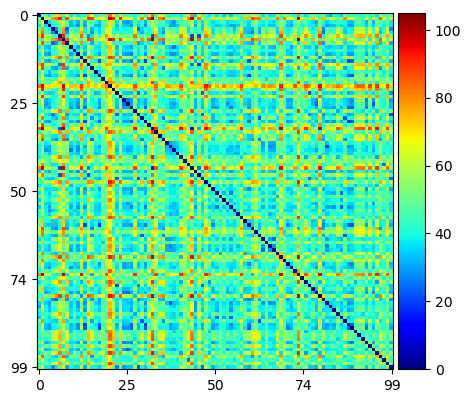

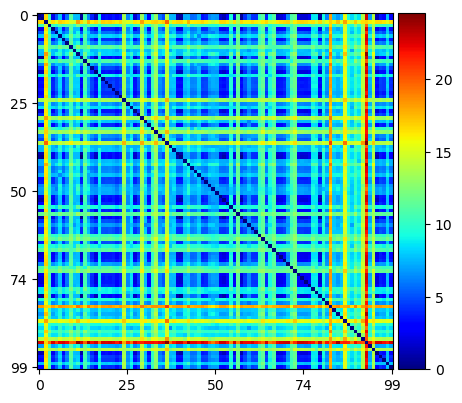

In [94]:
import scipy
k = 'text_embedding'

for k in ['text_embedding', 'grad_rp_loraB']:
    X = d[k][:100]

    D = scipy.spatial.distance_matrix(X, X, p=2)

    from rosemary import plt_kernel_matrix_one

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1,figsize=(5,5))
#     D = np.clip(D, a_min=0, a_max=50)
    plt_kernel_matrix_one(fig, ax, D)



In [90]:
# ind = np.argmax(D.sum(-1))
inds = D.sum(-1).argsort()[-3:][::1].tolist()
ds[inds]

{'dataset': ['flan2022', 'flan2022', 'flan2022'],
 'id': ['flan2022_2', 'flan2022_82', 'flan2022_92'],
 'messages': [[{'content': 'Choose your answer: Is "In Queensland, the Liberal and National parties merged in 2008 to form the new Liberal National Party of Queensland (registered as the Queensland Division of the Liberal Party of Australia)." a good answer to the question "In March 2012, which party won by an historic landslide?" Select from the following. i. yes; ii. no;\n',
    'role': 'user'},
   {'content': 'i.', 'role': 'assistant'}],
  [{'content': "Leonard Maltin compared this film to a Mel Brooks comedy. He was far too kind to Ms. Rivers, and far too cruel to Mr. Brooks. Not even the raunchiest Mel Brooks films are this tasteless, and at least they're genuinely funny. This picture deserves a place on the hundred-worst list. Choose your answer. What is the sentiment of this review? Select from: -negative. -positive.\n",
    'role': 'user'},
   {'content': 'negative', 'role': '

In [85]:

from note_pruning_analysis import get_dataset

ds = get_dataset(dataset)
ds


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Dataset({
    features: ['dataset', 'id', 'messages'],
    num_rows: 1000000
})

In [ ]:


t0 = time.time()

if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg=l2n, el2n_agg=mean
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in lm_output_dir={lm_output_dir}')
        return
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    random.seed(seed)
    inds = list(range(N))
    random.shuffle(inds)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    inds = sort_dpp_map(emb, log_prob, kernel_type=kernel_type)
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')

if any(sort_by.startswith(x) for x in ['dpp', 'random']):
    save_to_pickle(
        save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
        output={'inds': inds})
else:
    save_sorted_inds(save_dir, S, sort_by, reverse=False)
    save_sorted_inds(save_dir, S, sort_by, reverse=True)

In [ ]:
a = np.random.rand(10000,4096).astype(np.float32)
b = np.random.rand(10000,4096).astype(np.float32)
%timeit np.sum(a*b,axis=-1)

In [ ]:
a = np.random.rand(10000,4096).astype(np.float64)
b = np.random.rand(10000,4096).astype(np.float64)
%timeit np.sum(a*b,axis=-1)